In [1]:
from Run import Run
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from dk_utilities import get_signal_times

In [24]:
# get baseline information (from random triggers without beam)

folder = "C:/Users/Karlen/Documents/temp/"

#run_baseline = Run.open_file(folder+"run_000503.dk")
run_baseline = Run.open_file(folder+"run_000592.dk")
baseline_means = run_baseline.user['baseline_means']
baseline_stds = run_baseline.user['baseline_stds']

In [35]:
# special runs:
# 464 - no electron veto
# 502 - random during spill (no electron veto)
# 503 - random during beam off
# others: 388, 452, 463, 474

run_number = 678

run = Run.open_file(folder+"run_000"+str(run_number)+".dk")
config = run.config

if 'signal_times' in run.user:
    signal_times = run.user['signal_times']
else:
    signal_times = None

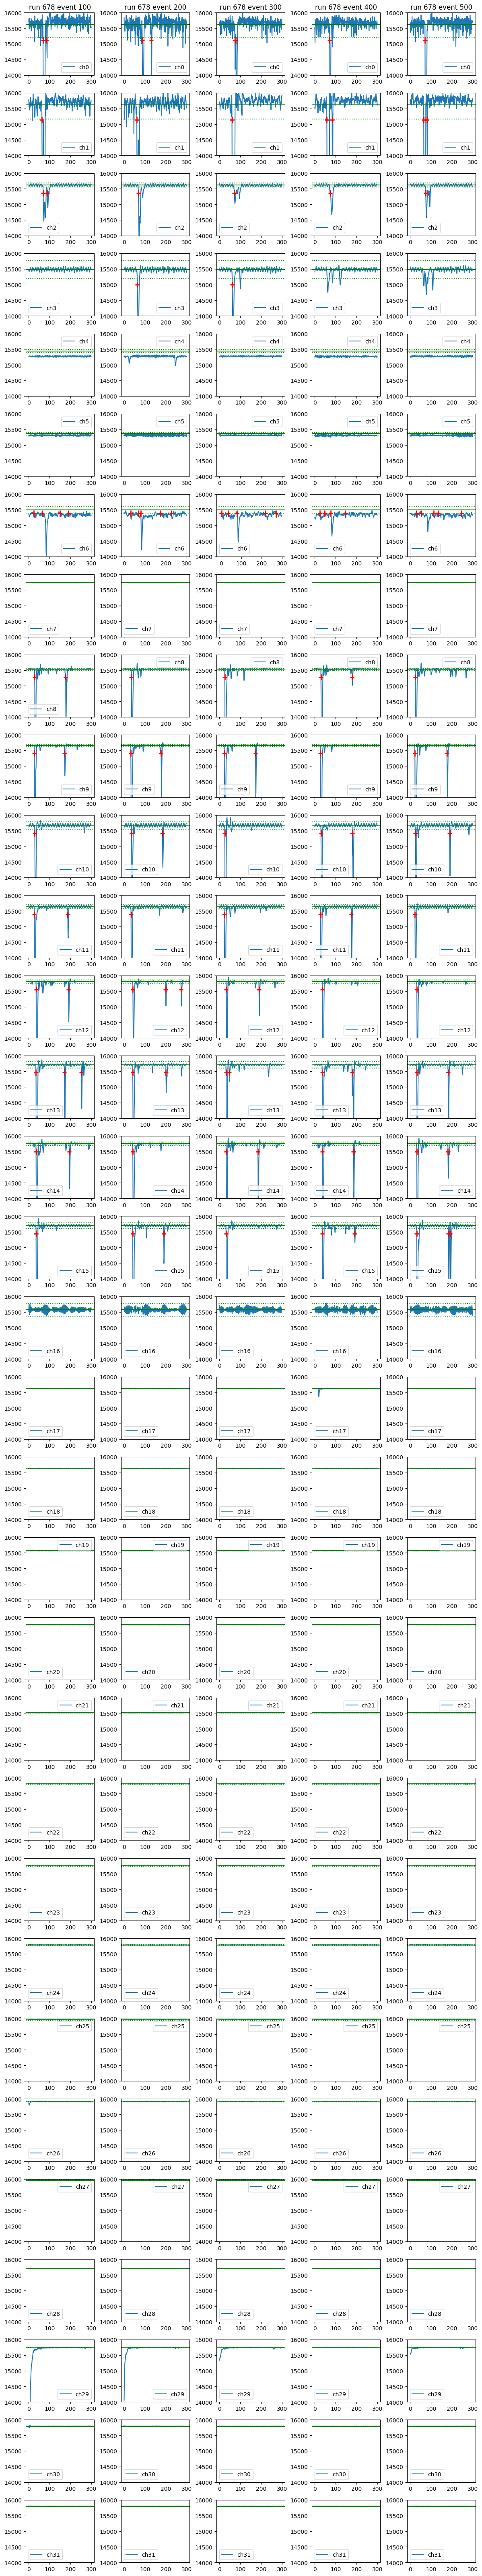

In [36]:
# look at beam structure: two peak events

def plot_wave_base(axis, waveform, c, time_bin_crossings=None):
    axis.plot(waveform, label='ch'+str(c))
    axis.set_ylim(14000,16000)
    axis.axhline(y=baseline_means[c], color='g')
    axis.axhline(y=baseline_means[c]+3*baseline_stds[c], color='g', ls=':')
    axis.axhline(y=baseline_means[c]-3*baseline_stds[c], color='g', ls=':')
    axis.legend()
    if time_bin_crossings is not None:
        threshold = config['peak_find_thresholds'][c]
        for time_bin_crossing in time_bin_crossings:
            axis.hlines(y=baseline_means[c]-threshold, xmin=time_bin_crossing-10, xmax=time_bin_crossing+10, color='r', lw=2.)
            axis.vlines(x=time_bin_crossing, ymin=baseline_means[c]-threshold-100, ymax=baseline_means[c]-threshold+100, color='r', lw=2.)

#n_p = 2
#has_2_peaks = np.where((run.analyses[2].n_peaks == n_p) & (run.analyses[3].n_peaks == n_p) & (run.analyses[2].n_peaks == n_p) & (run.analyses[3].n_peaks == n_p))
#has_2_peaks = np.where((run.analyses[16].n_peaks == n_p) | (run.analyses[17].n_peaks == n_p))
#n_events = 5
#event_list = has_2_peaks[0][:n_events]

event_list = np.array([100,200,300,400,500])
n_events = len(event_list)

if run_number <= 578:
    chan_set = 'act23'

    if chan_set == 'trig0':
        channels = [0,1,2,3]
    elif chan_set == 'trig1':
        channels = [4,5,6,7]
    elif chan_set == 'act01':
        channels = [8,9,10,11]
    elif chan_set == 'act23':
        channels = [12,13,14,15]
    elif chan_set == 'other':
        channels = [16,17,18]

else:
    chan_set = 'other'

    if chan_set == 'act':
        channels = [0,1,2,3,4,5]
    elif chan_set == 'trig0':
        channels = [8,9,10,11]
    elif chan_set == 'trig1':
        channels = [12,13,14,15]
    elif chan_set == 'hodo0':
        channels = [23,22,21,20]
    elif chan_set == 'hodo1':
        channels = [19,18,17]
    elif chan_set == 'hodo2':
        channels == [31,30,29,28]
    elif chan_set == 'hodo3':
        channels = [27,26,25,24]
    elif chan_set == 'other':
        channels = [6,16]

channels = range(32)
n_channels = len(channels)

fig, axs = plt.subplots(n_channels, n_events, figsize=(12, n_channels*2))
fig.tight_layout()
for ie, e in enumerate(event_list):
    axs[0][ie].set_title("run " + str(run_number) + " event " + str(e))

for ic, c in enumerate(channels):
    analysis = run.analyses[c]
    for ie, e in enumerate(event_list):
        waveform = analysis.raw_waveforms[e]
        if signal_times is not None and ie < len(signal_times[c]) and len(signal_times[c][e]) > 0:
            plot_wave_base(axs[ic][ie], waveform, c, signal_times[c][e])
        else:
            plot_wave_base(axs[ic][ie], waveform, c)

plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
plt.show()

[89.3893323970981]


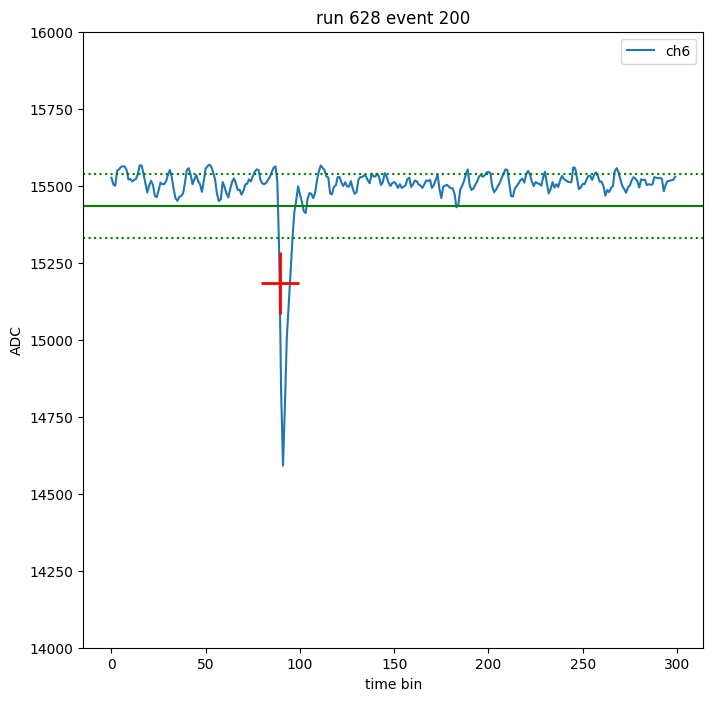

In [18]:
fig, axis = plt.subplots(1, 1, figsize=(8,8))
channel = 0
event = 200
analysis = run.analyses[channel]
waveform = analysis.raw_waveforms[event]
plot_wave_base(axis, waveform, channel, signal_times[channel][event])
print(signal_times[channel][event])
plt.title("run " + str(run_number) + " event " + str(event))
#plt.savefig(folder+'waveform_'+str(run_number)+'_'+str(event)+'_'+'channel'+'.png')
plt.xlabel('time bin')
plt.ylabel('ADC')
plt.show()

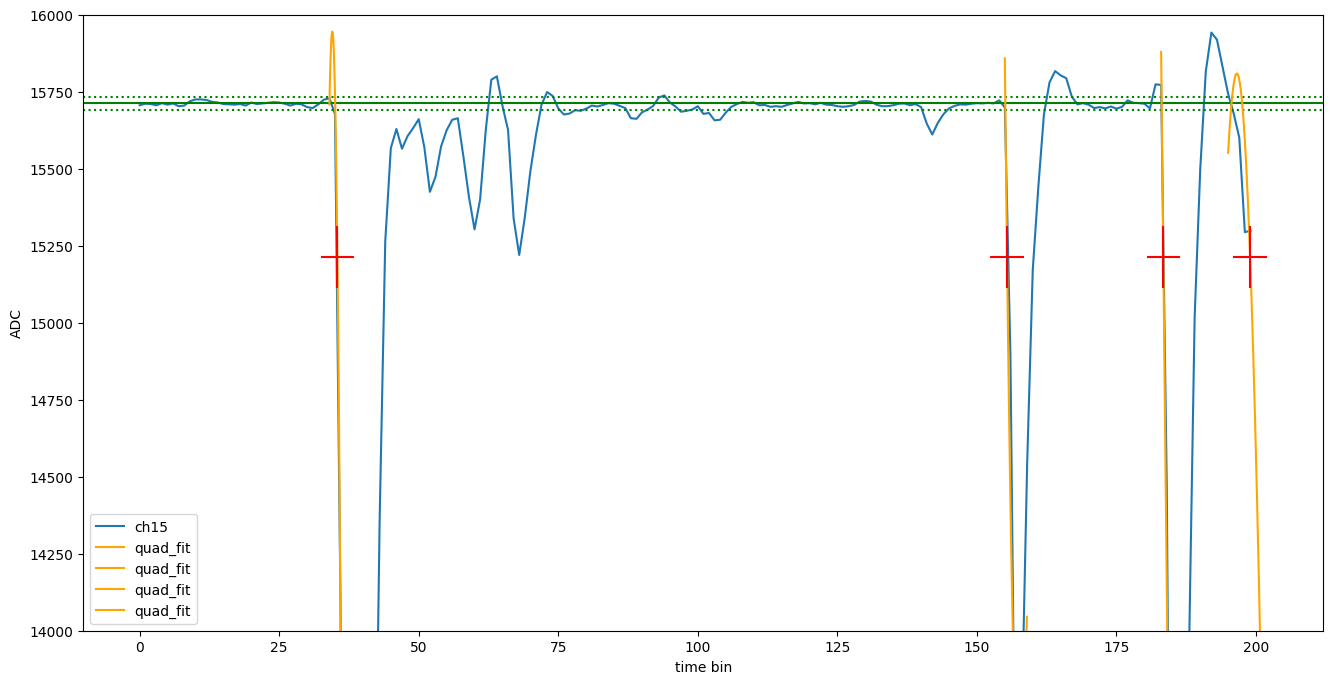

In [370]:
# simple threshold crossing estimate

channel = 15
event = 20000
threshold = config["peak_find_thresholds"][channel]
min_amplitude = config["peak_min_amplitudes"][channel]

def get_time_bin_crossing(start, n_samples, waveform):
    ts = np.array([start+i for i in range(n_samples)])
    amps = np.array([waveform[its] for its in ts])
    z = np.polyfit(ts, amps, 2)
    a, b, c = z[0], z[1], z[2]

    # fine binning for plot and for linear interpolation
    fine = 20
    tsf = np.array([start+i/(1.*fine) for i in range(fine*n_samples)])
    quad_fit = a*tsf*tsf+b*tsf+c

    deviations = quad_fit-baseline_means[channel]+threshold
    crossed_threshold = np.where(deviations<0.)[0][0]
    slope = (quad_fit[crossed_threshold] - quad_fit[crossed_threshold-1])*fine
    time_bin_crossing = start + crossed_threshold/fine - deviations[crossed_threshold]/slope

    return time_bin_crossing, tsf, quad_fit

analysis = run.analyses[channel]
waveform = analysis.raw_waveforms[event, range(210)]
# time bins that waveform is below -3*sigma
condition = (waveform-baseline_means[channel] < -3*baseline_stds[channel])
times_exceed_3sigma = np.where(condition)[0]

# time bins that waveform drops below -min_amplitude:
condition = (waveform-baseline_means[channel] < -1*min_amplitude)
times_exceed_min_amplitude = np.where(condition)[0]

# time bins that waveform is within -3*sigma
condition = (waveform-baseline_means[channel] > -3*baseline_stds[channel])
times_within_3sigma = np.where(condition)[0]

# loop over peaks: must return to within 3 sigma before another peak is considered
ready = False
exceeded_3sigma = False
peak_ranges = []

baseline_mean = baseline_means[channel]
baseline_std = baseline_stds[channel]
for t_bin in range(len(waveform)):
    if ready:
        exceeded_3sigma = (waveform[t_bin] - baseline_mean) < -3*baseline_std
        if exceeded_3sigma:
            time_bin_exceed_3sigma = t_bin-1
            ready = False
    if exceeded_3sigma:
        if (waveform[t_bin] - baseline_mean) < -1*min_amplitude:
            peak_ranges.append([time_bin_exceed_3sigma,t_bin])
            exceeded_3sigma = False

    ready = (waveform[t_bin] - baseline_mean) > -3*baseline_std

# select data to fit
#start = max(0,times_exceed_3sigma[0]-1)
#end = min(start+4, times_exceed_min_amplitude[0])
#n_samples = end-start+1

time_bin_crossings = []

fig, axis = plt.subplots(1, 1, figsize=(16,8))
plot_wave_base(axis, waveform[0:200], channel)
for peak_range in peak_ranges:
    start = peak_range[0]
    end = peak_range[1]
    n_samples = max(4,end-start+1)
    time_bin_crossing, tsf, quad_fit = get_time_bin_crossing(start, n_samples, waveform)
    time_bin_crossings.append(time_bin_crossing)

    plt.plot(tsf, quad_fit, label="quad_fit", color='orange')
    axis.hlines(y=baseline_means[channel]-threshold, xmin=time_bin_crossing-3, xmax=time_bin_crossing+3, color='r')
    axis.vlines(x=time_bin_crossing, ymin=baseline_means[channel]-threshold-100, ymax=baseline_means[channel]-threshold+100, color='r')
    axis.set_xlabel('time bin')
    axis.set_ylabel('ADC')
plt.legend()

plt.savefig(folder+'waveform_fit_'+str(run_number)+'_'+str(event)+'_'+'channel'+'.png')
plt.show()


ch8 mean,sig: -6.640853583968584 0.6184502530811837
ch12 mean,sig: -6.2087001745538295 42.77604954285198


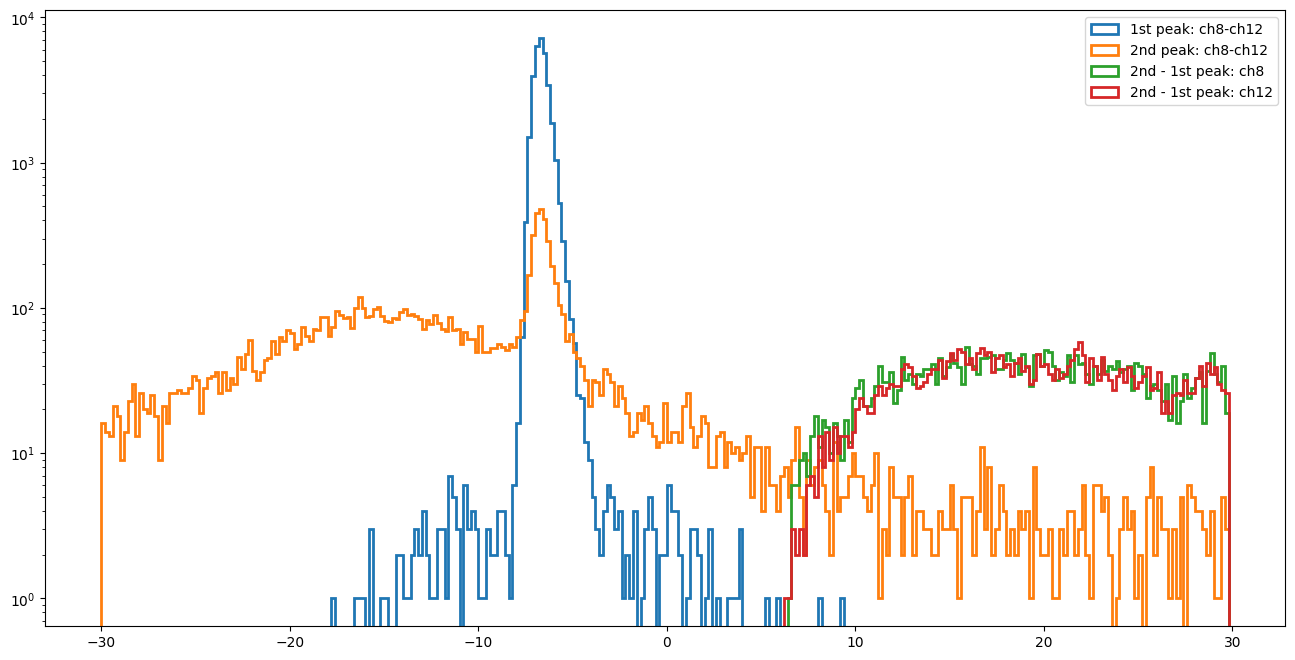

In [324]:
channels = [8,12]
time_diffs21 = [[],[]]
time_diffs1 = []
time_diffs2 = []

for ie in range(len(signal_times[0])):
    if len(signal_times[channels[0]][ie]) == 1 and len(signal_times[channels[1]][ie]) == 1:
        time_diffs1.append(signal_times[channels[0]][ie][0] - signal_times[channels[1]][ie][0])
    if len(signal_times[channels[0]][ie]) == 2 and len(signal_times[channels[1]][ie]) == 2:
        time_diffs2.append(signal_times[channels[0]][ie][1] - signal_times[channels[1]][ie][1])
    if len(signal_times[channels[0]][ie]) > 1:
        time_diffs21[0].append(signal_times[channels[0]][ie][1] - signal_times[channels[0]][ie][0])
    if len(signal_times[channels[1]][ie]) > 1:
        time_diffs21[1].append(signal_times[channels[1]][ie][1] - signal_times[channels[1]][ie][0])

print(f'ch{channels[0]} mean,sig:', np.mean(time_diffs1), np.std(time_diffs1))
print(f'ch{channels[1]} mean,sig:', np.mean(time_diffs2), np.std(time_diffs2))
fig, axis = plt.subplots(1, 1, figsize=(16,8))
str_chans = 'ch'+str(channels[0])+'-ch'+str(channels[1])
plt.hist(time_diffs1,bins=np.arange(-30,30.,0.2),label='1st peak: '+str_chans,histtype='step', linewidth=2)
plt.hist(time_diffs2,bins=np.arange(-30,30.,0.2),label='2nd peak: '+str_chans,histtype='step', linewidth=2)
plt.hist(time_diffs21[0],bins=np.arange(-30,30.,0.2),label='2nd - 1st peak: ch'+str(channels[0]),histtype='step', linewidth=2)
plt.hist(time_diffs21[1],bins=np.arange(-30,30.,0.2),label='2nd - 1st peak: ch'+str(channels[1]),histtype='step', linewidth=2)
plt.legend()
plt.yscale('log')
plt.show()

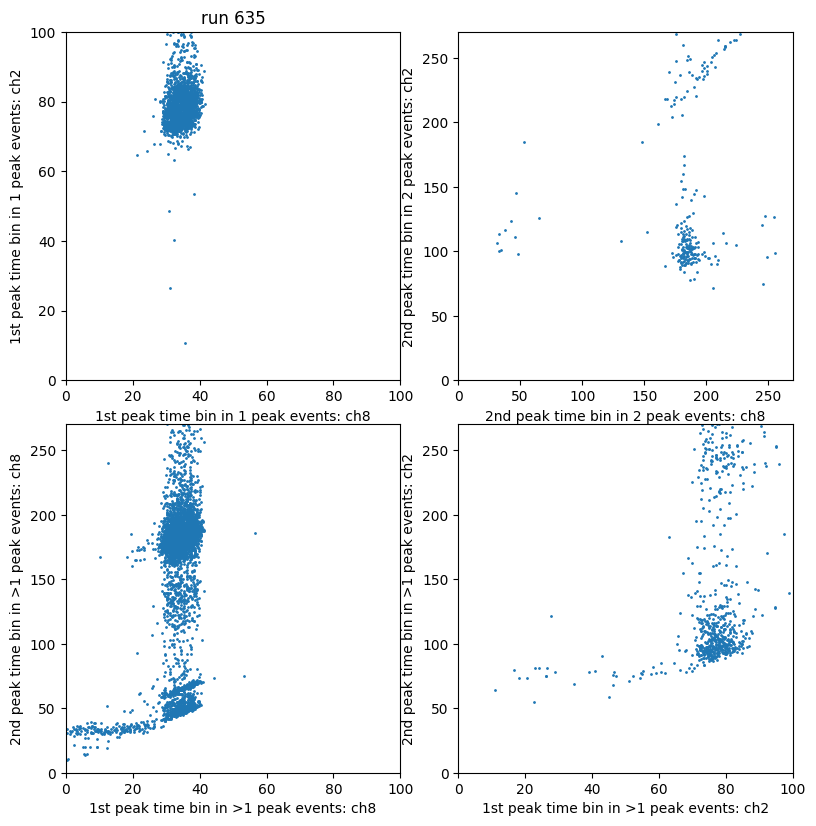

In [34]:
# look at scatter plots of times
channels = [8,2]
times1 = [[],[]]
times2 = [[],[]]
times21 = [[[],[]],[[],[]]]

for ie in range(len(signal_times[0])):
    if len(signal_times[channels[0]][ie]) == 1 and len(signal_times[channels[1]][ie]) == 1:
        times1[0].append(signal_times[channels[0]][ie][0])
        times1[1].append(signal_times[channels[1]][ie][0])
    if len(signal_times[channels[0]][ie]) == 2 and len(signal_times[channels[1]][ie]) == 2:
        times2[0].append(signal_times[channels[0]][ie][1])
        times2[1].append(signal_times[channels[1]][ie][1])
    if len(signal_times[channels[0]][ie]) > 1:
        times21[0][0].append(signal_times[channels[0]][ie][0])
        times21[0][1].append(signal_times[channels[0]][ie][1])
    if len(signal_times[channels[1]][ie]) > 1:
        times21[1][0].append(signal_times[channels[1]][ie][0])
        times21[1][1].append(signal_times[channels[1]][ie][1])

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()

axes[0][0].set_title("run " + str(run_number))

axes[0][0].scatter(times1[0],times1[1],s=1)
axes[0][0].set_xlabel('1st peak time bin in 1 peak events: ch'+str(channels[0]))
axes[0][0].set_ylabel('1st peak time bin in 1 peak events: ch'+str(channels[1]))
axes[0][0].set_xlim(0,100)
axes[0][0].set_ylim(0,100)

axes[0][1].scatter(times2[0],times2[1],s=1)
axes[0][1].set_xlabel('2nd peak time bin in 2 peak events: ch'+str(channels[0]))
axes[0][1].set_ylabel('2nd peak time bin in 2 peak events: ch'+str(channels[1]))
axes[0][1].set_xlim(0,270)
axes[0][1].set_ylim(0,270)

axes[1][0].scatter(times21[0][0],times21[0][1],s=1)
axes[1][0].set_xlabel('1st peak time bin in >1 peak events: ch'+str(channels[0]))
axes[1][0].set_ylabel('2nd peak time bin in >1 peak events: ch'+str(channels[0]))
axes[1][0].set_xlim(0,100)
axes[1][0].set_ylim(0,270)

axes[1][1].scatter(times21[1][0],times21[1][1],s=1)
axes[1][1].set_xlabel('1st peak time bin in >1 peak events: ch'+str(channels[1]))
axes[1][1].set_ylabel('2nd peak time bin in >1 peak events: ch'+str(channels[1]))
axes[1][1].set_xlim(0,100)
axes[1][1].set_ylim(0,270)

plt.savefig(folder+'time_scatter_'+str(run_number)+'_'+'ch'+str(channels[0])+'_ch'+str(channels[1])+'.png')
plt.show()

In [37]:
analysis = run.analyses[29]
waveform = analysis.raw_waveforms[10]

In [38]:
len(waveform)

300